## Семинар 7: "Методы оптимизации"

ФИО: Янкова Анастасия Алексеевна

In [1]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, RMSProp, Adadelta, Adam.

### Часть 1: Реализация методов

Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [2]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):   
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)
    
    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

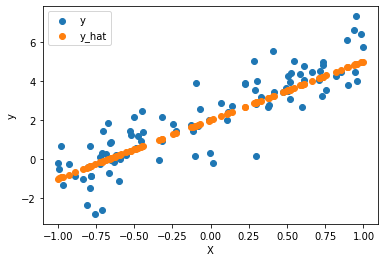

In [3]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

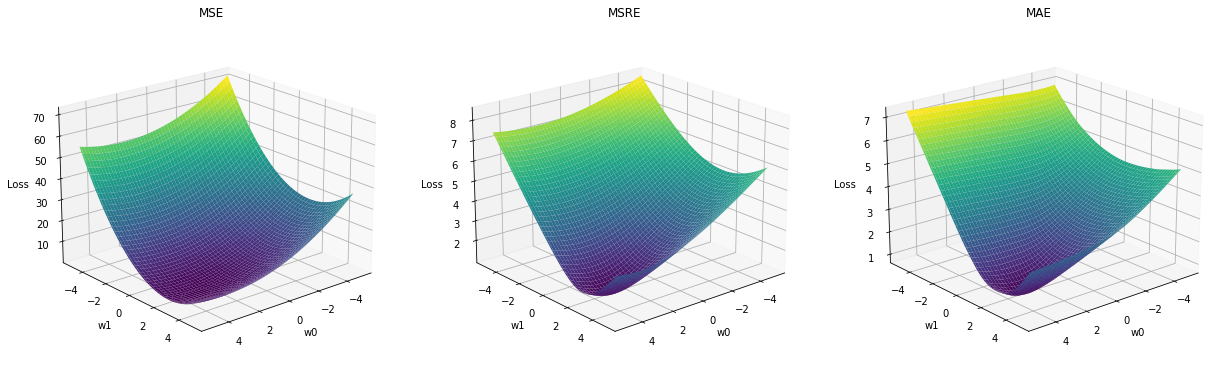

In [4]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

<i> 1.1 Реализуйте методы SGD, Momentum, NAG, Adagrad, Adadelta, Adam.</i> **(1 балл)**

In [5]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()
    
    def pre_step(self):
        pass
    
    def step(self):
        pass
    
    def update_param(self, p):
        raise NotImplementedError()


In [6]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [7]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }
    
    return loss_animator.animate(num_iter, data, step_skip=step_skip)

 Реализуйте методы SGD, Momentum, NAG, Adagrad, Adadelta, Adam.

In [8]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad
        

In [9]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma = 0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma
        self.m = {p: torch.zeros_like(p.data) for p in self.params}
        
    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                self.m[p] = self.gamma * self.m[p] + self.lr * p.grad
                p -= self.m[p]

In [35]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma = 0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma
        self.m = {p: torch.zeros_like(p.data) for p in self.params}
        
    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                new_p = nn.Parameter((p - self.gamma * self.m[p]), requires_grad=True)
                print(p)
                print(p.requires_grad)
                print(p.is_leaf)
                print(new_p)
                print(new_p.requires_grad)
                print(new_p.is_leaf)
                #new_p.backward(retain_graph=True)
                new_p.backward() 
                print(p.grad)
                print(new_p.grad)
                self.m[p] = self.gamma * self.m[p] + self.lr * new_p.grad
                p -= self.m[p]

In [11]:
class Adagrad(Optimizer):
    def __init__(self, params, lr=1e-2, epsilon = 1e-8):
        super().__init__(params)
        self.lr = lr
        self.epsilon = epsilon
        self.G = {p: torch.zeros_like(p.data) for p in self.params}

        
    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                g = p.grad
                print(g)
                self.G[p] += g * g
                p -= self.lr * g / torch.sqrt(self.G[p] + self.epsilon)

In [12]:
class Adadelta(Optimizer):
    def __init__(self, params, lr=1e-2, gamma = 0.9, epsilon = 1e-8):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.ma = {p: torch.zeros_like(p.data) for p in self.params}
        self.delta = {p: torch.zeros_like(p.data) for p in self.params}
        
        
    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                g = p.grad
                self.ma[p] = self.gamma * self.ma[p] + (1 - self.gamma) * (g **2)
                g = g * torch.sqrt((self.delta[p] + self.epsilon) / (self.ma[p] + self.epsilon))
                p -= g
                self.delta[p] = self.gamma + (1 - self.gamma) *( g **2)

In [13]:
class Adam(Optimizer):
    def __init__(self, params, lr=1e-2, beta1 = 0.9, beta2 = 0.99, epsilon = 1e-8):
        super().__init__(params)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {p: torch.zeros_like(p.data) for p in self.params}
        self.v = {p: torch.zeros_like(p.data) for p in self.params}
        
    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                self.m[p] = self.beta1 * self.m[p] + (1 - self.beta1) * p.grad
                self.v[p] = self.beta2 * self.v[p] + (1 - self.beta2) * (p.grad) ** 2
                p -= self.lr * self.m[p] / (torch.sqrt(self.v[p]) + self.epsilon) 

In [14]:
from functools import partial

points_SGD, losses_SGD = optimize_function(partial(loss_animator.loss_func, loss=mse), SGD, {'lr': 1e-1}, start_point=[-20, -20], num_iter=100)

In [15]:
points_momentum, losses_momentum = optimize_function(partial(loss_animator.loss_func, loss=mse), Momentum, {'lr': 1e-1}, start_point=[-20, -20], num_iter=100)

In [16]:
points_momentum, losses_momentum = optimize_function(partial(loss_animator.loss_func, loss=mse), Momentum, {'lr': 1e-1}, start_point=[-20, -20], num_iter=100)

<i1> 1.2 Сравните реализованные методы на предложенном примере **(1 балл)**

In [36]:
optimizers = []
optimizers.append(['SGD', SGD, {'lr': 1e-1}])
optimizers.append(['Momentum', Momentum, {'lr': 1e-1, 'gamma' : 0.9}])
#optimizers.append(['NAG', NAG, {'lr': 1e-1, 'gamma' : 0.9}])
optimizers.append(['Adagrad', Adagrad, {'lr': 0.1, 'epsilon': 1e-8}])
optimizers.append(['Adadelta', Adadelta, {'lr': 1e-1, 'gamma':  0.9, 'epsilon': 1e-8}])
optimizers.append(['Adam', Adam, {'lr': 1e-1, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}])


In [23]:
optimizers

[['SGD', __main__.SGD, {'lr': 0.1}],
 ['Momentum', __main__.Momentum, {'lr': 0.1, 'gamma': 0.9}],
 ['NAG', __main__.NAG, {'lr': 0.1, 'gamma': 0.9}],
 ['Adagrad', __main__.Adagrad, {'lr': 0.1, 'epsilon': 1e-08}],
 ['Adadelta', __main__.Adadelta, {'lr': 0.1, 'gamma': 0.9, 'epsilon': 1e-08}],
 ['Adam',
  __main__.Adam,
  {'lr': 0.1, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08}]]

In [37]:
compare_optimizers(loss_animator,mse,optimizers,start_point=[-20, -20])

Parameter containing:
tensor([-20., -20.], requires_grad=True)
True
True
Parameter containing:
tensor([-20., -20.], requires_grad=True)
True
True


RuntimeError: ignored

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). Для обучения используйте оптимизаторы из первой части, а не из pytorch. </i> **(2 балла)**

In [20]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2023-03-01 19:16:19--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2023-03-01 19:16:19--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.10’

MNIST.tar.gz.10         [           <=>      ]  33.20M  15.0MB/s    in 2.2s    

2023-03-01 19:16:22 (15.0 MB/s) - ‘MNIST.tar.gz.10’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/r

In [21]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i> **(1 балл)**

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: